# Simplification of encoding models based on tuning curves.



In [1]:
# Import useful modules
import os
import scipy
import random as rand
from scipy import io as sio
from scipy import stats
from scipy.stats.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import itertools

import pickle
import itertools
import time

import copy

import multiprocessing as mp

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import neural_proba
from neural_proba import distrib
from neural_proba import tuning_curve
from neural_proba import voxel
from neural_proba import experiment
from neural_proba import fmri

import utils

In [2]:
pwd

'/home/tb258044/Documents/code'

### To avoid scrolling windows

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Properties of the models

Here are the properties related to :
- the tuning curves (types, number, variance, ...) both true and fitted. 
- the neural mixture (sparsities)
- the subjects
- the sessions
- the SNR
- the type of linear regression performed

In [4]:
# All parameters are here

# Define the seed to reproduce results from random processes
rand.seed(4);

# INPUTS

# The parameters related to the scheme
scheme_array = ['gaussian_ppc', 'sigmoid_ppc', 'gaussian_dpc', 'sigmoid_dpc']
n_schemes = len(scheme_array)

# The parameters related to the tuning curves to be explored

N_array = np.array([2, 3, 4, 5, 6, 7, 8, 10, 14, 20])

t_mu_gaussian_array = np.array([0.15, 0.12, 0.1, 8e-2, 7e-2, 6e-2, 5e-2, 4e-2, 3e-2, 2e-2])
t_conf_gaussian_array = np.array([0.25, 0.2, 0.15, 0.12, 0.10, 9e-2, 8e-2, 6e-2, 4e-2, 3e-2])

# # Even N
#N_array = np.array([2, 4, 6, 8, 10, 14, 20])

#t_mu_gaussian_array = np.array([0.15, 0.1, 7e-2, 5e-2, 4e-2, 3e-2, 2e-2])
#t_conf_gaussian_array = np.array([0.25, 0.15, 0.10, 8e-2, 6e-2, 4e-2, 3e-2])


t_mu_sigmoid_array = np.sqrt(2*np.pi)/4*t_mu_gaussian_array
t_conf_sigmoid_array = np.sqrt(2*np.pi)/4*t_conf_gaussian_array

# Lower and upper bounds of the encoded summary quantity (for tuning curves) established from the histograms
tc_lower_bound_mu = 0
tc_upper_bound_mu = 1
tc_lower_bound_conf = 1.1
tc_upper_bound_conf = 2.6

# The number of N to be tested
n_N = len(N_array)

# The number of fractions tested (related to W): one per sparsity level combination
n_fractions = 20

# Sparsity exponents
sparsity_exp_array = np.array([1, 2, 4, 8])
n_sparsity_exp = len(sparsity_exp_array)

# The number of subjects
n_subjects = 1000

# The number of sessions
n_sessions = 4

# Experimental options
n_stimuli = 380    # The number of stimuli per session

between_stimuli_duration = 1.3
min_break_time = 8
max_break_time = 12
min_n_local_regular_stimuli = 12    # Min number of stimuli before a break
max_n_local_regular_stimuli = 18    # Max number of stimuli before a break


# Transition proba or Bernoulli proba
distrib_type = 'transition'    #'bernoulli' or 'transition' 

# Load the corresponding data
[p1_dist_array, p1_mu_array, p1_sd_array] = neural_proba.import_distrib_param(n_subjects, n_sessions, n_stimuli, distrib_type)

# SNR as defined by ||signal||²/(||signal||²+||noise||²). Mind the squares!
snr = 0.1

# fMRI info
final_frame_offset = 10  # Frame recording duration after the last stimulus has been shown
initial_frame_time = 0
dt = 0.125  # Temporal resolution of the fMRI scanner

between_scans_duration = 2  # in seconds
final_scan_offset = 10  # Scan recording duration after the last stimulus has been shown


# Type of regression
regr = linear_model.LinearRegression(fit_intercept=True, n_jobs=-1)
regr2 = linear_model.LinearRegression(fit_intercept=True, n_jobs=-1)

whitening_done = False


0.2192206952456889
0.28385972778202867


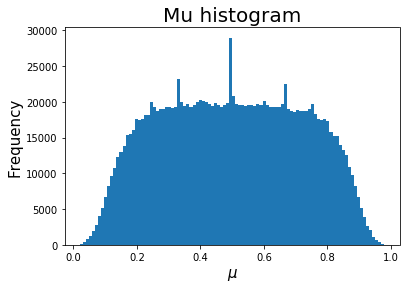

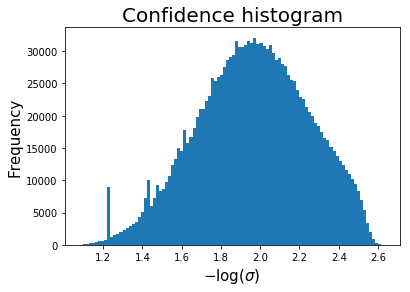

In [18]:
# Histograms of the distribution
all_mu = np.concatenate(p1_mu_array).ravel()    # All values of mu (for percentiles)

all_conf = -np.log(np.concatenate(p1_sd_array).ravel())    # All values of conf (for percentiles)

# The quantity used for 
print(np.std(all_mu))
print(np.std(all_conf))
# To get the percentiles

fontsize=15
fig = plt.figure()
plt.hist(all_mu, bins=100)
plt.title("Mu histogram", fontsize=fontsize+5)
plt.xlabel(r"$\mu$", fontsize=fontsize)
plt.ylabel("Frequency", fontsize=fontsize)
plt.show()

fig = plt.figure()
plt.hist(all_conf, bins=100)
plt.title("Confidence histogram", fontsize=fontsize+5)
plt.xlabel(r"$-\log(\sigma)$", fontsize=fontsize)
plt.ylabel("Frequency", fontsize=fontsize)
plt.show()

mu_percentiles = np.percentile(all_mu, np.linspace(0, 100, 100))

conf_percentiles = np.percentile(all_conf, np.linspace(0, 100, 100))


## Handle the data

### Raw data loading and visualization


In [5]:
# Load the design matrices and specify their size
#with open("output/design_matrices/X.txt", "rb") as fp: "X.txt", "rb") as fp:   # Unpickling
#    X = pickle.load(fp)

In [5]:
# Just for now
n_subjects = 1000

# Create the matrix with all the possibilities (mu or 1-mu encoded in each session) of size 16x4
n_directions = list(itertools.product([0,1], repeat=4))
n_directions = np.array(n_directions)

## Handle the data

### Raw data loading and visualization


In [6]:
# Some reloading (one should run it if the loops have already been performed and results saved)
r2_raw_train = np.load('/volatile/bounmy/output/results/snr0.1/'+str(distrib_type)+'/all/1000subjects_r2_raw_train_snr0.1.npy')
rho_raw_train = np.load('/volatile/bounmy/output/results/snr0.1/'+str(distrib_type)+'/all/1000subjects_rho_raw_train_snr0.1.npy')
r2_true_train = np.load('/volatile/bounmy/output/results/snr0.1/'+str(distrib_type)+'/all/1000subjects_r2_true_train_snr0.1.npy')
rho_true_train = np.load('/volatile/bounmy/output/results/snr0.1/'+str(distrib_type)+'/all/1000subjects_rho_true_train_snr0.1.npy')

r2_raw_test = np.load('/volatile/bounmy/output/results/snr0.1/'+str(distrib_type)+'/all/1000subjects_r2_raw_test_snr0.1.npy')
rho_raw_test = np.load('/volatile/bounmy/output/results/snr0.1/'+str(distrib_type)+'/all/1000subjects_rho_raw_test_snr0.1.npy')
r2_true_test = np.load('/volatile/bounmy/output/results/snr0.1/'+str(distrib_type)+'/all/1000subjects_r2_true_test_snr0.1.npy')
rho_true_test = np.load('/volatile/bounmy/output/results/snr0.1/'+str(distrib_type)+'/all/1000subjects_rho_true_test_snr0.1.npy')

In [7]:
#n_subjects = 1000

r2_raw_train_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
r2_raw_test_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
rho_raw_train_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
rho_raw_test_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
r2_true_train_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
r2_true_test_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
rho_true_train_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
rho_true_test_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))

for k_scheme, k_fit_N, k_true_N in itertools.product(range(n_schemes), range(n_N), range(n_N)):
    
    r2_raw_train_summary[k_scheme, k_fit_N, k_true_N, :] = r2_raw_train[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    rho_raw_train_summary[k_scheme, k_fit_N, k_true_N, :] = rho_raw_train[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    r2_true_train_summary[k_scheme, k_fit_N, k_true_N, :] = r2_true_train[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    rho_true_train_summary[k_scheme, k_fit_N, k_true_N, :] = rho_true_train[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    
    r2_raw_test_summary[k_scheme, k_fit_N, k_true_N, :] = r2_raw_test[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    rho_raw_test_summary[k_scheme, k_fit_N, k_true_N, :] = rho_raw_test[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    r2_true_test_summary[k_scheme, k_fit_N, k_true_N, :] = r2_true_test[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    rho_true_test_summary[k_scheme, k_fit_N, k_true_N, :] = rho_true_test[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()

In [8]:
print(r2_raw_train.shape)

(4, 10, 10, 20, 1000, 4)


### Visualize results from simulation 1 (one example)

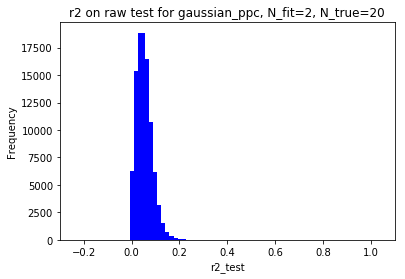

r2 var: 0.0009744190581504731
r2 mean: 0.055287928565879746


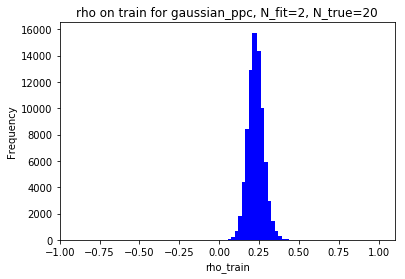

rho var: 0.0022786206901035952
rho mean: 0.2366843121703062


In [10]:
# Visualize one specific histogram over r2 or rho

#########################################
k_scheme = 0
k_fit_N = 0
k_true_N = -1
# Metric
metric_name = 'r2'
true_or_raw = 'raw'
train_or_test = 'test'

##########################################

scheme = scheme_array[k_scheme]
fit_N = N_array[k_fit_N]
true_N = N_array[k_true_N]

exec("metric = %s_%s_%s_summary[k_scheme, k_fit_N, k_true_N]" % (metric_name, true_or_raw, train_or_test))

nbins = 20
width = 0.03
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.hist(metric, bins=nbins, align='left', color='b', width=width)
#ax.bar(negative_center, n_negative_values, color='r', width=2*width, align='center')
ax.set_title(metric_name+' on '+true_or_raw+' '+train_or_test+' for '+scheme+', N_fit='+str(fit_N)+', N_true='+str(true_N))
ax.set_xlabel('{}_{}'.format(metric_name, train_or_test))
ax.set_ylabel("Frequency")
ax.set_xlim([-0.3, 1.1])
plt.show()

print('r2 var: '+str(np.var(metric)))
print('r2 mean: '+str(np.mean(metric)))

fig.savefig("figures_tmp/fit_example_histogram_r2_N_fit"+str(fit_N)+"_N_true"+str(true_N)+"_snr"+str(snr)+".pdf", bbox_inches='tight')

# rho
metric_name = 'rho'
true_or_raw = 'raw'
train_or_test = 'train'
exec("metric = %s_%s_%s_summary[k_scheme, k_fit_N, k_true_N]" % (metric_name, true_or_raw, train_or_test))

nbins = 20
width = 0.03
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.hist(metric, bins=nbins, align='left', color='b', width=width)
ax.set_title(metric_name+' on '+train_or_test+' for '+scheme+', N_fit='+str(fit_N)+', N_true='+str(true_N))
ax.set_xlabel('{}_{}'.format(metric_name, train_or_test))
ax.set_ylabel("Frequency")
ax.set_xlim([-1, 1.1])
plt.show()

print('rho var: '+str(np.var(metric)))
print('rho mean: '+str(np.mean(metric)))

fig.savefig("figures_tmp/fit_example_histogram_rho_N_fit"+str(fit_N)+"_N_true"+str(true_N)+"_snr"+str(snr)+".pdf", bbox_inches='tight')

## Plot confusion matrices for simulation 1

[0, 2, 4, 6, 7, 8, 9]
r2 on raw test set, sigmoid_dpc


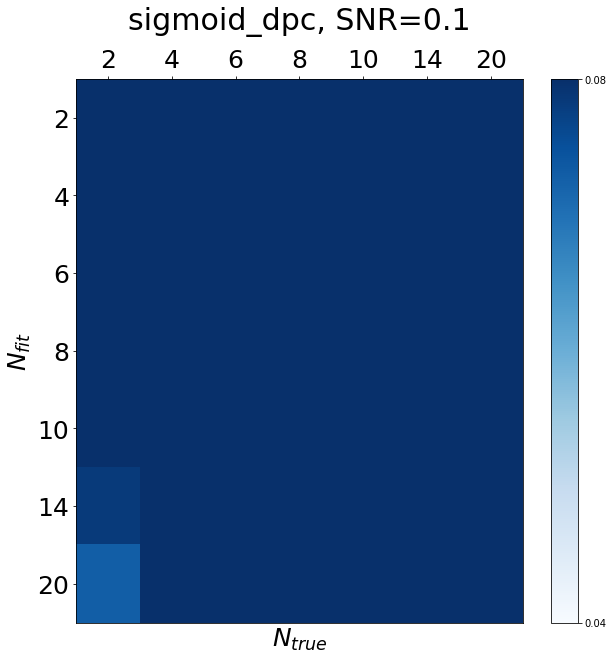

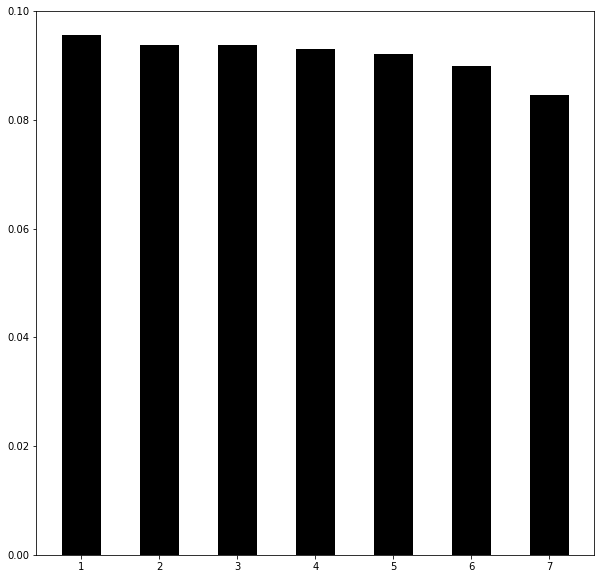

The index to keep is 0.
The optimal number of tuning curves is: 2.
Corresponding r2 mean score: 0.09556997654789645


In [17]:
################################
k_scheme = 3

################################
n_fractions = 20
scheme = scheme_array[k_scheme]

is_N_even = True

if is_N_even:
    selected_k_N = [0, 2, 4, 6, 7, 8, 9]
else:
    selected_k_N = [item for item in range(len(N_array))]

metric_name = 'r2'
true_or_raw = 'raw'
train_or_test = 'test'
print(selected_k_N)
#exec("metric = %s_%s_%s_summary[k_scheme, k_fit_N, k_true_N]" % (metric_name, true_or_raw, train_or_test))

print(metric_name+' on '+true_or_raw+' '+train_or_test+' set, '+scheme)

# Visualize the entire confusion matrix
nbins = 20
width = 0.04

#fig, ax = plt.subplots(n_N, n_N, sharex='col', sharey='row', figsize = (10, 10))
#for k_fit_N in range(n_N):
#    for k_true_N in range(n_N):
#        exec("metric = %s_%s_%s_summary[k_scheme, k_fit_N, k_true_N]" % (metric_name, true_or_raw, train_or_test))
#        fit_N = N_array[k_fit_N]
#        true_N = N_array[k_true_N]
#        # We set the negative r2 to the same value
#        negative_center = -0.2
#        n_negative_values = 0
#        if metric_name.find('r2')!=-1:
#            for k, metric_value in enumerate(metric):
#                if metric_value <0:
#                    metric[k] = negative_center
#                    n_negative_values += 1
#
#        ax[k_fit_N, k_true_N].hist(metric, bins=nbins, align='left', color='b', width=width)
#        ax[k_fit_N, k_true_N].bar(negative_center, n_negative_values, color='r', width=2*width, align='center')
#        ax[k_fit_N, k_true_N].set_title('N_fit='+str(fit_N)+', N_true='+str(true_N))
#        ax[k_fit_N, k_true_N].set_xlabel('{}_{}'.format(metric_name, train_or_test))
#        ax[k_fit_N, k_true_N].set_ylabel("Frequency")
#        if metric_name.find('r2')!=-1:
#            ax[k_fit_N, k_true_N].set_xlim([-0.3, 1.1])
#        else:
#            ax[k_fit_N, k_true_N].set_xlim([-1, 1])
#        ax[k_fit_N, k_true_N].set_ylim([0, n_fractions*n_subjects*n_sessions/4])
#fig.tight_layout()
#plt.show()

# Plot the confusion matrix of the mean
column_labels = copy.deepcopy(N_array[selected_k_N])
row_labels = copy.deepcopy(N_array[selected_k_N])

fig, ax = plt.subplots(figsize=(10,10))
fontsize = 25
exec("metric = copy.deepcopy(%s_%s_%s_summary[k_scheme, :, :, :])" % (metric_name, true_or_raw, train_or_test))
# We set the negative r2 to the same value
data = np.mean(metric[selected_k_N, :, :], axis=2)
data = data[:, selected_k_N]
min_value = 0.04
max_value = 0.1

heatmap = ax.pcolor(data, cmap=plt.cm.Blues, vmin=min_value, vmax=max_value)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False, fontsize=fontsize)
ax.set_yticklabels(row_labels, minor=False, fontsize=fontsize)
ax.set_ylabel('$N_{fit}$', fontsize=fontsize)
ax.set_xlabel('$N_{true}$', fontsize=fontsize)
plt.title(scheme+', SNR='+str(snr), y=1.08, fontsize=fontsize+5)
cbar = fig.colorbar(heatmap, ticks=[min_value, max_value])
# Bar plots of the mean over the column
mean_r2 = np.mean(data,axis=1)
fig_bar, ax_bar = plt.subplots(figsize=(10, 10))
ax_bar.bar(np.linspace(1, len(mean_r2), len(mean_r2), endpoint=True), mean_r2, color='black', width=0.5, align='center')
ax_bar.set_ylim([0, 0.1])

plt.show()

if is_N_even:
    fig.savefig("figures_tmp/simu1_results_"+distrib_type+"_scheme-"+scheme+"_snr"+str(snr)+"_EVEN.pdf", bbox_inches='tight')
    fig_bar.savefig("figures_tmp/simu1_means_"+distrib_type+"_scheme-"+scheme+"_snr"+str(snr)+"_EVEN.pdf", bbox_inches='tight')
else:
    fig.savefig("figures_tmp/simu1_results_"+distrib_type+"_scheme-"+scheme+"_snr"+str(snr)+"_ALL.pdf", bbox_inches='tight')
    fig_bar.savefig("figures_tmp/simu1_means_"+distrib_type+"_scheme-"+scheme+"_snr"+str(snr)+"_ALL.pdf", bbox_inches='tight')

# Final scores:
res = np.argmax(mean_r2)
index = selected_k_N[res]
print(f'The index to keep is {res}.')
print(f'The optimal number of tuning curves is: {N_array[index]}.')
print(f'Corresponding r2 mean score: {np.amax(mean_r2)}')

In [17]:
###### DEBUG CELL! Scatter plots to visualize amplitude of y_sd compared to r2

sd_y_true = np.zeros((n_schemes, n_N, n_fractions, n_subjects, n_sessions))
sd_y = np.zeros((n_schemes, n_N, n_fractions, n_subjects, n_sessions))

for k_scheme, k_true_N, k_fraction, k_subject, k_session in itertools.product(range(n_schemes), 
                                                                            range(n_N), range(n_fractions), range(n_subjects), range(n_sessions)):
    sd_y_true[k_scheme, k_true_N, k_fraction, k_subject, k_session] = np.std(yz_without_noise[k_scheme][k_true_N][k_fraction][k_subject][k_session])

for k_scheme, k_true_N, k_fraction, k_subject, k_session in itertools.product(range(n_schemes), 
                                                                            range(n_N), range(n_fractions), range(n_subjects), range(n_sessions)):
    sd_y[k_scheme, k_true_N, k_fraction, k_subject, k_session] = np.std(yz[k_scheme][k_true_N][k_fraction][k_subject][k_session])


k_scheme = 1

print(r2_raw_test.shape)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for k_true_N in range(n_N):
    x = sd_y[k_scheme, k_true_N, :, :, :].flatten()
    y = r2_raw_test[k_scheme, 4, k_true_N, :, :, :].flatten()
    ax.scatter(x, y, s=10, label='N ='+str(N_array[k_true_N]))
ax.set_xlabel('y std')
ax.set_ylabel('r2_test')
ax.legend()
plt.show()

NameError: name 'yz_without_noise' is not defined

### Find the optimal number of subjects to be generated

Plot the mean and variance of these distributions for different number of subjects

In [164]:
# Find the assymptotical value for n_fractions
n_subjects_array = np.linspace(1, n_subjects, num=int(n_subjects/5), endpoint=True).astype(int)

subject_r2_train_mean = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))
subject_r2_train_var = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))

subject_r2_test_mean = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))
subject_r2_test_var = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))

subject_r2_true_test_mean = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))
subject_r2_true_test_var = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))

subject_rho_train_mean = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))
subject_rho_train_var = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))

subject_rho_test_mean = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))
subject_rho_test_var = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))

for k_n_subjects, n_subjects in enumerate(n_subjects_array):
    for k_scheme, k_fit_N, k_true_N in itertools.product(range(n_schemes), range(n_N), range(n_N)):            
        subject_r2_train_mean[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.mean(r2_train[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
        subject_r2_train_var[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.var(r2_train[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
                                      
        subject_r2_test_mean[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.mean(r2_test[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
        subject_r2_test_var[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.var(r2_test[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
        
        subject_r2_true_test_mean[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.mean(r2_true_test[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
        subject_r2_true_test_var[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.var(r2_true_test[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())

        subject_rho_train_mean[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.mean(rho_train[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
        subject_rho_train_var[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.var(rho_train[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())

        subject_rho_test_mean[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.mean(rho_test[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
        subject_rho_test_var[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.var(rho_test[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())

Scheme : sigmoid_ppc
true_N = 6
fit_N = 5



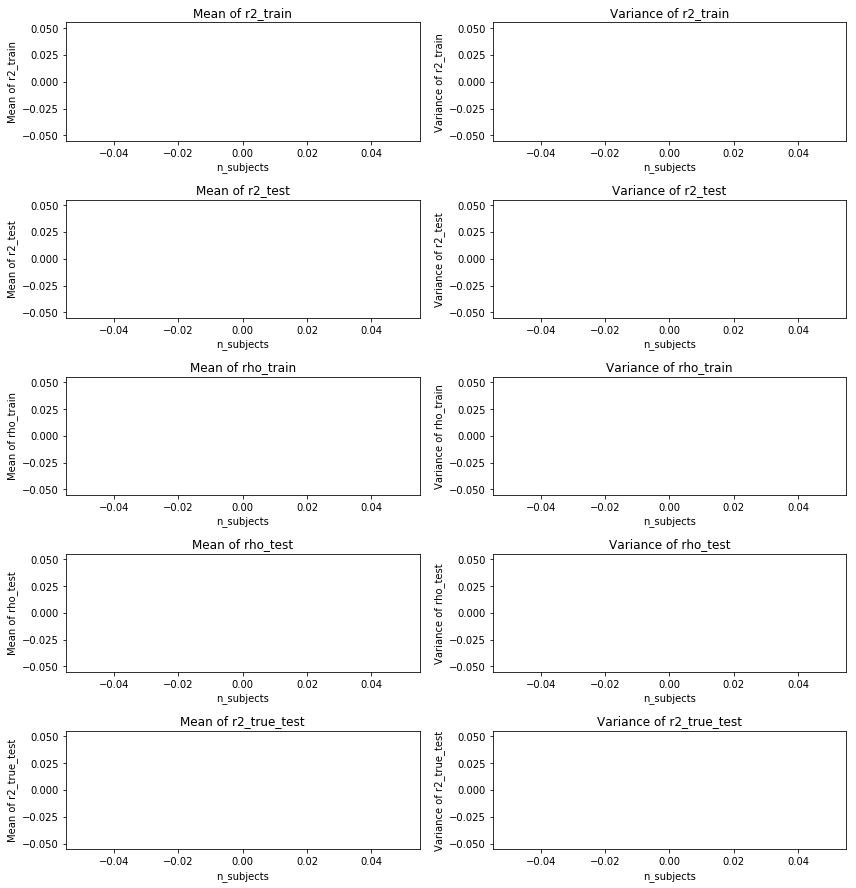

In [165]:
# Visualize the evolution of r2 according to the number of subjects
k_scheme = 1
k_fit_N = 3
k_true_N = 4

true_N = N_array[k_true_N]
fit_N = N_array[k_fit_N]

print('Scheme : '+scheme_array[k_scheme]+'\n'+'true_N = '+str(true_N)+'\nfit_N = '+str(fit_N)
      +'\n')

subject_r2_train_mean_to_plot = subject_r2_train_mean[k_scheme, k_fit_N, k_true_N, :]
subject_r2_train_var_to_plot = subject_r2_train_var[k_scheme, k_fit_N, k_true_N, :]

subject_r2_test_mean_to_plot = subject_r2_test_mean[k_scheme, k_fit_N, k_true_N, :]
subject_r2_test_var_to_plot = subject_r2_test_var[k_scheme, k_fit_N, k_true_N, :]

subject_rho_train_mean_to_plot = subject_rho_train_mean[k_scheme, k_fit_N, k_true_N, :]
subject_rho_train_var_to_plot = subject_rho_train_var[k_scheme, k_fit_N, k_true_N, :]

subject_rho_test_mean_to_plot = subject_rho_test_mean[k_scheme, k_fit_N, k_true_N, :]
subject_rho_test_var_to_plot = subject_rho_test_var[k_scheme, k_fit_N, k_true_N, :]

subject_r2_true_test_mean_to_plot = subject_r2_true_test_mean[k_scheme, k_fit_N, k_true_N, :]
subject_r2_true_test_var_to_plot = subject_r2_true_test_var[k_scheme, k_fit_N, k_true_N, :]

fig = plt.figure(figsize=(12, 12))
ax_r2_train_mean = fig.add_subplot(521)
ax_r2_train_mean.plot(n_subjects_array, subject_r2_train_mean_to_plot)
ax_r2_train_mean.set_xlabel('n_subjects')
ax_r2_train_mean.set_ylabel('Mean of r2_train')
ax_r2_train_mean.set_title('Mean of r2_train')

ax_r2_train_var = fig.add_subplot(522)
ax_r2_train_var.plot(n_subjects_array, subject_r2_train_var_to_plot)
ax_r2_train_var.set_xlabel('n_subjects')
ax_r2_train_var.set_ylabel('Variance of r2_train')
ax_r2_train_var.set_title('Variance of r2_train')

ax_r2_test_mean = fig.add_subplot(523)
ax_r2_test_mean.plot(n_subjects_array, subject_r2_test_mean_to_plot)
ax_r2_test_mean.set_xlabel('n_subjects')
ax_r2_test_mean.set_ylabel('Mean of r2_test')
ax_r2_test_mean.set_title('Mean of r2_test')

ax_r2_test_var = fig.add_subplot(524)
ax_r2_test_var.plot(n_subjects_array, subject_r2_test_var_to_plot)
ax_r2_test_var.set_xlabel('n_subjects')
ax_r2_test_var.set_ylabel('Variance of r2_test')
ax_r2_test_var.set_title('Variance of r2_test')

ax_rho_train_mean = fig.add_subplot(525)
ax_rho_train_mean.plot(n_subjects_array, subject_rho_train_mean_to_plot)
ax_rho_train_mean.set_xlabel('n_subjects')
ax_rho_train_mean.set_ylabel('Mean of rho_train')
ax_rho_train_mean.set_title('Mean of rho_train')

ax_rho_train_var = fig.add_subplot(526)
ax_rho_train_var.plot(n_subjects_array, subject_rho_train_var_to_plot)
ax_rho_train_var.set_xlabel('n_subjects')
ax_rho_train_var.set_ylabel('Variance of rho_train')
ax_rho_train_var.set_title('Variance of rho_train')

ax_rho_test_mean = fig.add_subplot(527)
ax_rho_test_mean.plot(n_subjects_array, subject_rho_test_mean_to_plot)
ax_rho_test_mean.set_xlabel('n_subjects')
ax_rho_test_mean.set_ylabel('Mean of rho_test')
ax_rho_test_mean.set_title('Mean of rho_test')

ax_rho_test_var = fig.add_subplot(528)
ax_rho_test_var.plot(n_subjects_array, subject_rho_test_var_to_plot)
ax_rho_test_var.set_xlabel('n_subjects')
ax_rho_test_var.set_ylabel('Variance of rho_test')
ax_rho_test_var.set_title('Variance of rho_test')
fig.tight_layout()

ax_r2_true_test_mean = fig.add_subplot(5,2, 9)
ax_r2_true_test_mean.plot(n_subjects_array, subject_r2_true_test_mean_to_plot)
ax_r2_true_test_mean.set_xlabel('n_subjects')
ax_r2_true_test_mean.set_ylabel('Mean of r2_true_test')
ax_r2_true_test_mean.set_title('Mean of r2_true_test')

ax_r2_true_test_var = fig.add_subplot(5,2,10)
ax_r2_true_test_var.plot(n_subjects_array, subject_r2_true_test_var_to_plot)
ax_r2_true_test_var.set_xlabel('n_subjects')
ax_r2_true_test_var.set_ylabel('Variance of r2_true_test')
ax_r2_true_test_var.set_title('Variance of r2_true_test')


plt.show()